# Nichtlineare Systeme und Maschinelles Lernen

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Definiere ein nichtlineares System: Tank mit Zu- und Ablauf

$h(t) = A_{zu} /A \int{u(t) dt} - A_{abfluss}/A \sqrt{2 g} \int{\sqrt{h(t)} dt}$ 

Überführung in eine Zustandsdarstellung

$ \dot{h}(t) = 1/A u(t) - A_{abfluss}/A \sqrt{2 g} \sqrt{h(t)}$

Zeitdiskretisierung 

$ \dot{h}(t) \approx \frac{h(k+1) - h(k) }{T} $

In [2]:
# Anzahl der Zeitschritte für die Simulation des Tanks
n_iter = 1000
T = 0.01
x = np.zeros(n_iter)
u = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
u_white = np.random.normal(0.2, 0.4, n_iter)

# TP-Filter 1. Ordnung
filter_T = 0.05
for k in range(n_iter):
    u[k] = (1-filter_T)*u[k-1] + filter_T*u_white[k]

# Parametrierung und Simulation des Zustandsraummodells
# Parameter: Verhältnisse der Querschnitte von Behälter, Zulauf und Ablauf
A = 10
Aab = 0.5
Azu = 0.5
for k in range(n_iter-1):
    x[k+1] = Azu/A * T * u [k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200 # Die Skalierung wird nur vorgenommen, um die Plots von u und h einfacher übereinander darstellen zu könnnen

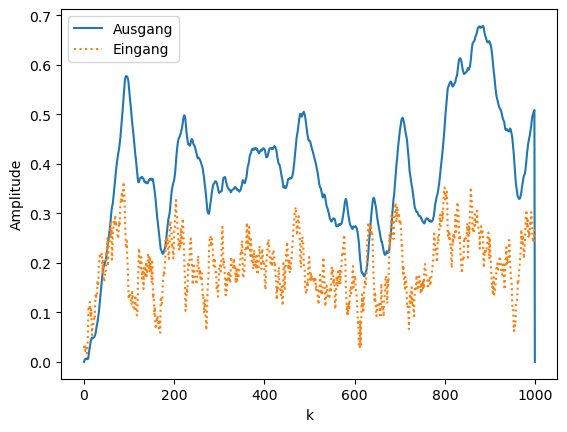

In [3]:
plt.figure()
plt.plot(h, label= 'Ausgang')
plt.plot(u,linestyle=':', label='Eingang')
plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

## Versuch der Schätzung eines nichtlinearen Modells

In [4]:
import sklearn.svm as skm

Anordnen der Daten 

In [5]:
# Regressor
phi = np.zeros((n_iter, 2))
for k in range(n_iter):
    phi[k, :] = [u[k-1], h[k-1]]

### Erkundung des Raums der Eingangsvektoren 

Für dieses einfache Beispiel gibt es nur 2 Eingänge: Das Steuersignal u(k-1) und die Füllhöhe h(k-1) aus dem letzten Rechenschritt, aus denen die Füllhöhe h(k) bestimmt werden soll. 

Was bewirkt eine Änderung der Länge des Trainingsdatensatzes (n_iter)?

Text(0, 0.5, 'h[k-1]')

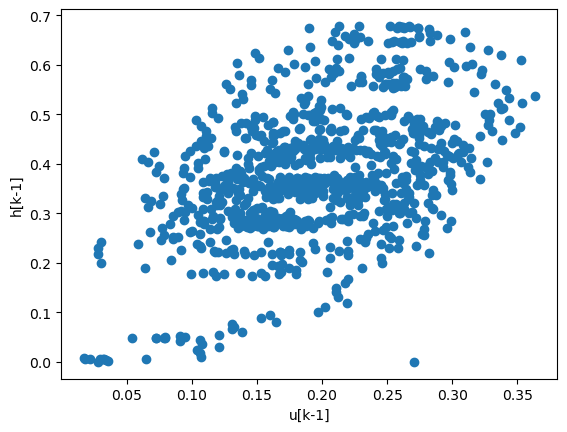

In [6]:
plt.figure()
plt.scatter(phi[:,0], phi[:,1])
plt.xlabel('u[k-1]')
plt.ylabel('h[k-1]') 

Testen verschiedener Modelle aus Scikit Learn.

GridSearch trainiert verschiedene Modelle im durch param_grid aufgespannten Paramterraum und ermittelt die beste Lösung.  
Die Prozedur kann je nach Größe des Grids und der Länge der Trainingsdaten sehr zeitaufwändig werden!

Interessant ist die Untersuchung, wie sich verschiedene Parametersätze und auch Längen des Trainingsdatensatzes auswirken.


In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
clf_grid = GridSearchCV(skm.SVR(kernel='rbf', gamma=1, epsilon = 0.001),
                   param_grid={"C": [ 1e3, 1e4],
                               "gamma": np.logspace(-2, 2, 4)})

clf_grid.fit(phi, h)

GridSearchCV(estimator=SVR(epsilon=0.001, gamma=1),
             param_grid={'C': [1000.0, 10000.0],
                         'gamma': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02])})

In [9]:
clf  = clf_grid.best_estimator_ 

In [10]:
# Prädiktion mit den Ausgangswerten aus den Trainingsdaten, die im Regressor gesammelt wurden
h_predict = clf.predict(phi)

Zum Vergleich wird noch ein lineares Modell (ARX) identifiziert

Die bereits im Regressor angeordneten Daten können einfach erneut verwendet werden.


In [11]:
ARX, residuals, rank, s = np.linalg.lstsq(phi,h,-1)

Simulation: Berechnung der Ausgangssignale des Modells 

Iteration durch die Zeitreihe des Eingangssignals, Vorhersage des Ausgangssignals aus dem Eingangssignal und dem Abtastwert des Ausgangssignals im letzten Zeitschritt

In [12]:
# Simulation - Berechnung des Ausgangssignals aus dem Modell
hdach_simulation = np.zeros_like(x)
for k in range(n_iter-1):
    phi_sample = np.array([u[k], hdach_simulation[k]])
    phi_sample = np.reshape(phi_sample,(1,-1))
                                          
    hdach_simulation[k+1] = clf.predict(phi_sample)

Betrachtung des durch die Eingangsvektoren aufgespannten Raums und die Positionierung der Mittelpunkte der Basisfunktionen des nichtlinearen Modells. 

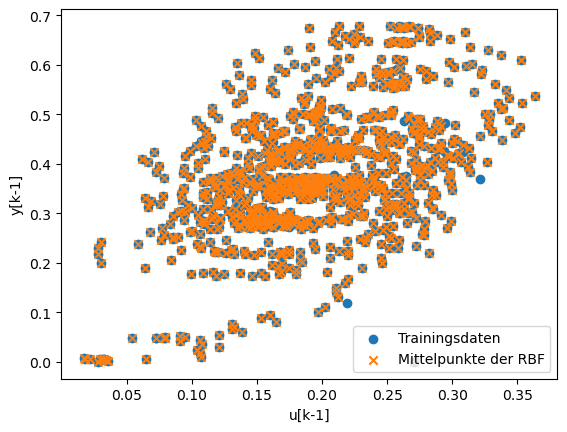

In [13]:
plt.figure()
plt.scatter(phi[:,0], phi[:,1], label = 'Trainingsdaten')
plt.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1] , label='Mittelpunkte der RBF', marker='x')
plt.xlabel('u[k-1]')
plt.ylabel('y[k-1]')
plt.legend()

Das Modell enthält unter Umständen eine sehr große Anzahl an Parametern, hier also Mittelpunkten der RBF

In [14]:
np.size(clf.support_vectors_)

1946

### Testen des trainierten Modells mit einem neuem Datensatz 

In [15]:
# Anzahl der Zeitschritte für die Simulation des Tanks
n_iter = 1000
T = 0.01
x = np.zeros(n_iter)
u_test = np.zeros_like(x)
h = np.zeros_like(x)

# TP-gefiltertes weisses Rauschen als Eingangssignal
u_white = np.random.normal(0.2,0.4,n_iter)

# TP-Filter 1. Ordnung
for k in range(n_iter):
    u_test[k] = (1-filter_T)*u_test[k-1] + filter_T*u_white[k]


for k in range(n_iter-1):
    x[k+1] = Azu/A * T * u_test[k] -  T*  Aab/A * np.sqrt(2.0*9.81) * np.sqrt(x[k]) + x[k]
    
    if x[k+1] < 0.0:
        x[k+1] = 0.0
        
    h[k] = x[k]*200

In [16]:
# Regressor
phi = np.zeros((n_iter, 2))
for k in range(n_iter):
    phi[k, :] = [u_test[k-1], h[k-1]]

In [17]:
hdach_simulation_test = np.zeros_like(x)
for k in range(n_iter-1):
    phi_sample = np.array([u_test[k], hdach_simulation_test[k]])
    phi_sample = np.reshape(phi_sample,(1,-1))
                                          
    hdach_simulation_test[k+1] = clf.predict(phi_sample)

Simulation des ARX Modells

In [18]:
t = np.arange(n_iter)
#t, h_dach_arx, xout = ctl.forced_response(sys, t , u_test)
h_dach_arx = np.zeros_like(x)
for k in range(n_iter-1):
    h_dach_arx[k+1] = np.dot(ARX, [u_test[k], h_dach_arx[k]])

Plotten der Modelle.  

Interessant ist zu beobachten, wo das lineare Modell am meisten abweicht, und bei welchen Konfigurationen das nichtlineare Modell tatsächlich deutlich besser ist.

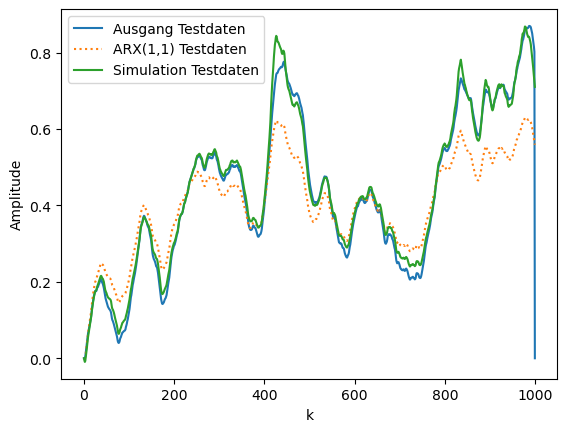

In [19]:
plt.figure()
#plt.plot(u_test, linestyle=':', label='Eingang Testdaten')
plt.plot(h, label = 'Ausgang Testdaten' )
plt.plot(h_dach_arx.T, ':', label = 'ARX(1,1) Testdaten')
plt.plot(hdach_simulation_test, label='Simulation Testdaten')

plt.xlabel('k')
plt.ylabel('Amplitude')
plt.legend()

Erweiterung 